In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import os
import pickle as pkl
import matplotlib as mpl
import copy
import colorcet as cc
from scipy import interpolate

cwd = os.getcwd()
hwd = os.path.dirname(cwd)
dir_dls = os.path.join(hwd, "DLS-git")
print(dir_dls)
sys.path.append(dir_dls)

from DLScommonTools import *
from unpackConfigurationsMK import *
from LRBv21 import *


%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()


c:\Users\mikek\OneDrive\Project\DLS\DLS-git


# IO

In [2]:
file_paths = {
    "V10" : os.path.join(hwd, r"STEPv10\drsep0mm\balance_v10.nc"),
     "V10X" : os.path.join(hwd, r"from_sarah\V10Xgluedgrid_balance\balance.nc"),
     "SPR38" : os.path.join(hwd, r"STEP_SPR038\drsep0mm\balance_SPR038.nc")}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for design in designs:  
    eqb[design] = dict()

    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 1000)

In [3]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Density wider scan

In [20]:
BxBt_scale = 5
Lc_scale = 5
design = "SPR38"
side = "iu"

d = copy.deepcopy(eqb[design][side])
constants = constants_default.copy()
radios = radios_default.copy()
                    
d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                    
radios["upstreamGrid"] = True
constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint
constants["nu0"] = 1e20

# Inner has 10% of the power.
if side == "iu":
    constants["qpllu0"] = constants_default["qpllu0"] * 0.1

SparRange = [0]    
out = LRBv21(constants, radios, d, SparRange, verbosity = 3, control_variable = "density", timeout = 10)


Solving...0...
---SOLVING FOR INDEX 0
qpllu0: 1.000E+08 | nu: 1.000E+20 | Tu: 117.7 | cz: 2.000E-02 | cvar: 1.00E+20 -> qpllu1: 4.532E+09 | Tucalc: 314.3 | error1: 4.532E+01

cvar: 1.000E+20, error1: 4.532E+01
qpllu0: 1.000E+08 | nu: 5.000E+19 | Tu: 117.7 | cz: 2.000E-02 | cvar: 5.00E+19 -> qpllu1: 2.005E+09 | Tucalc: 250.7 | error1: 2.005E+01
cvar: 5.000E+19, error1: 2.005E+01
Last error: 4.532E+01, New error: 2.005E+01
qpllu0: 1.000E+08 | nu: 2.500E+19 | Tu: 117.7 | cz: 2.000E-02 | cvar: 2.50E+19 -> qpllu1: 8.949E+08 | Tucalc: 202.1 | error1: 8.949E+00
cvar: 2.500E+19, error1: 8.949E+00
Last error: 2.005E+01, New error: 8.949E+00
qpllu0: 1.000E+08 | nu: 1.250E+19 | Tu: 117.7 | cz: 2.000E-02 | cvar: 1.25E+19 -> qpllu1: 4.354E+08 | Tucalc: 168.5 | error1: 4.354E+00
cvar: 1.250E+19, error1: 4.354E+00
Last error: 8.949E+00, New error: 4.354E+00
qpllu0: 1.000E+08 | nu: 6.250E+18 | Tu: 117.7 | cz: 2.000E-02 | cvar: 6.25E+18 -> qpllu1: 2.700E+08 | Tucalc: 150.9 | error1: 2.700E+00
cvar: 6.2

In [18]:
out.keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Tprofiles', 'Sprofiles', 'Qprofiles', 'Rprofiles', 'logs', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'spar_onset', 'spol_onset', 'constants', 'radios'])

## T profiles

In [9]:
len(out["logs"][0]["Tprofiles"])

16

[ 0.5        13.77111601 16.83271224 18.95151335 20.63097138]
[ 0.5        13.77111518 16.8327103  18.95151027 20.63096719]


(0.0, 100.9091084804857)

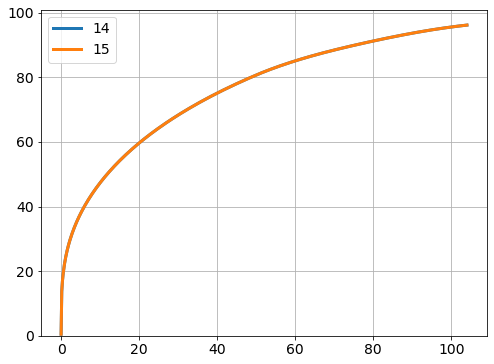

In [11]:
fig, ax = plt.subplots()

for i in [14,15]:
    ax.plot(out["Sprofiles"][0],out["logs"][0]["Tprofiles"][i], label = i)
    print(out["logs"][0]["Tprofiles"][i][:5])
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])

## Q profiles

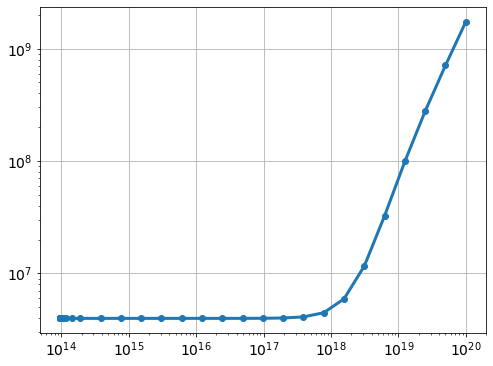

In [74]:
fig, ax = plt.subplots()
ax.plot(out["logs"][0]["cvar"], out["logs"][0]["qpllu1"], marker = "o")
ax.set_yscale("log")
ax.set_xscale("log")

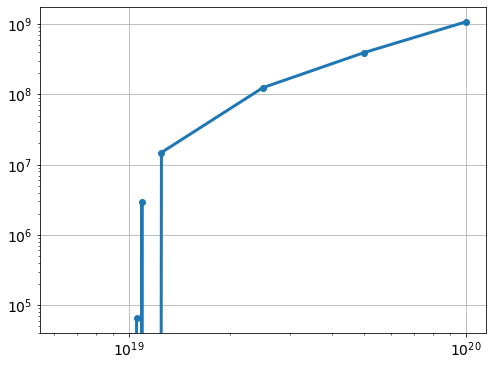

In [76]:
fig, ax = plt.subplots()
ax.plot(out["logs"][0]["cvar"], out["logs"][0]["qpllu1"], marker = "o")
ax.set_yscale("log")
ax.set_xscale("log")

Cvar 1e+20 | qpllu1  1729923451.8197176 || [4.17597226e+07 2.68504245e+08 3.70847615e+08 4.27910626e+08
 4.63269543e+08]
Cvar 5e+19 | qpllu1  708874714.8994704 || [4.17597226e+07 1.07916746e+08 1.48676469e+08 1.76173089e+08
 1.96365743e+08]
Cvar 2.5e+19 | qpllu1  277836913.7168165 || [41759722.5537524  59400619.35514384 72350352.08360614 82109674.45187508
 90014539.6302083 ]
Cvar 1.25e+19 | qpllu1  99348240.73844323 || [41759722.5537524  46416823.29368841 50092270.21754821 53047171.74299765
 55569272.61223856]
Cvar 6.25e+18 | qpllu1  32580073.6100585 || [41759722.5537524  43109143.72150129 44226505.35419116 45171441.28167579
 46012510.51594067]
Cvar 3.125e+18 | qpllu1  11640280.994720584 || [41759722.5537524  42278240.84477982 42738502.01879221 43155426.93516661
 43546267.12182095]
Cvar 1.5625e+18 | qpllu1  5937216.751595062 || [41759722.5537524  42070262.4590541  42365101.18344196 42648294.19476566
 42924485.35521271]
Cvar 7.8125e+17 | qpllu1  4475482.427923074 || [41759722.5537524  4

(0.0, 1816218845.7123618)

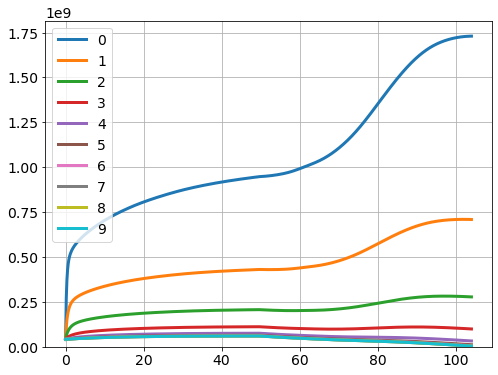

In [69]:
fig, ax = plt.subplots()

for i in range(10):
    ax.plot(out["Sprofiles"][0],out["logs"][0]["Qprofiles"][i], label = i)
    print(f'Cvar {out["logs"][0]["cvar"][i]} | qpllu1  {out["logs"][0]["qpllu1"][i]} || {out["logs"][0]["Qprofiles"][i][:5]}')
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])

Cvar 1e+20 | qpllu1  1078339104.225997 || [4.17597226e+07 2.67048949e+08 3.66666369e+08 4.20429016e+08
 4.52137082e+08]
Cvar 5e+19 | qpllu1  394833858.69980484 || [4.17597226e+07 1.07232317e+08 1.46886271e+08 1.73016874e+08
 1.91673652e+08]
Cvar 2.5e+19 | qpllu1  124698797.37466183 || [41759722.5537524  58930016.99767609 71294902.89355193 80386301.24763367
 87559065.13280666]
Cvar 1.25e+19 | qpllu1  14873487.002625432 || [41759722.5537524  46001886.76007185 49235006.34063764 51726811.11199662
 53768364.98144566]
Cvar 6.25e+18 | qpllu1  -28403997.85786118 || [41759722.5537524  42708304.53084946 43419893.47503691 43955185.78377235
 44382950.46344054]


(0.0, 1133676259.33019)

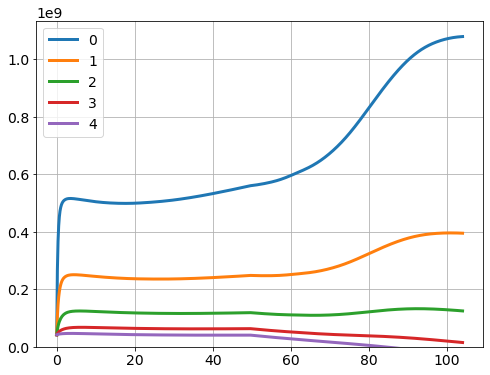

In [66]:
fig, ax = plt.subplots()

for i in range(5):
    ax.plot(out["Sprofiles"][0],out["logs"][0]["Qprofiles"][i], label = i)
    print(f'Cvar {out["logs"][0]["cvar"][i]} | qpllu1  {out["logs"][0]["qpllu1"][i]} || {out["logs"][0]["Qprofiles"][i][:5]}')
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])

In [59]:
out["logs"][0]["error1"]

[1,
 10.78339104225997,
 3.9483385869980485,
 1.2469879737466183,
 0.14873487002625432,
 -0.2840399785786118,
 -0.08347370143985038,
 0.029529505960917714,
 -0.027829438565752793,
 0.000647129136086754]

In [19]:
store = dict()

design = "SPR38"

# 
list_BxBt_scales = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[design][side])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["nu0"] = 1e19
            
            # Inner has 10% of the power.
            if side == "iu":
                constants["qpllu0"] = constants_default["qpllu0"] * 0.1
            constants["cz0"] = 0.05
            SparRange = [0, d["S"][d["Xpoint"]-1]]    
            out = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = "density")
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array

store["list_BxBt_scales"] = list_BxBt_scales
store["list_Lc_scales"] = list_Lc_scales

Running side: iu
Running BxBt scale factor: 0.25 -- Running Lc scale factor: 0.25 -- Solving...0...

c:\Users\mikek\OneDrive\Project\DLS\DLS-git\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
c:\Apps\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


104...Complete in 2.6 seconds
Running Lc scale factor: 0.38 -- Solving...0...104...Complete in 2.1 seconds
Running Lc scale factor: 0.50 -- Solving...0...104...Complete in 2.7 seconds
Running Lc scale factor: 0.62 -- Solving...0...104...Complete in 2.3 seconds
Running Lc scale factor: 0.75 -- Solving...0...104...Complete in 2.7 seconds
Running Lc scale factor: 0.88 -- Solving...0...104...Complete in 2.2 seconds
Running Lc scale factor: 1.00 -- Solving...0...104...Complete in 2.3 seconds
Running Lc scale factor: 1.25 -- Solving...0...104...Complete in 2.7 seconds
Running Lc scale factor: 1.50 -- Solving...0...104...Complete in 2.7 seconds
Running Lc scale factor: 1.75 -- Solving...0...104...Complete in 2.9 seconds
Running Lc scale factor: 2.00 -- Solving...0...104...Complete in 2.4 seconds
Running Lc scale factor: 2.25 -- Solving...0...104...Complete in 2.5 seconds
Running Lc scale factor: 2.50 -- Solving...0...104...Complete in 2.6 seconds
Running BxBt scale factor: 0.38 -- Running Lc 

c:\Apps\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


340...Complete in 4.0 seconds
Running Lc scale factor: 0.38 -- Solving...0...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******


c:\Users\mikek\OneDrive\Project\DLS\DLS-git\LRBv21.py:379: RuntimeWarning: invalid value encountered in double_scalars
  error0 = (Tu-Tucalc)/Tu


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration fact

c:\Users\mikek\OneDrive\Project\DLS\DLS-git\LRBv21.py:421: RuntimeWarning: invalid value encountered in double_scalars
  Qrad.append(((cvar**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******OUTER TIMEOUT! Loosen Ttol or reduce under-relaxation factor. Set verbosity = 2!*******
Complete in 106.2 seconds
Running Lc scale factor: 0.50 -- Solving...0...340...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol

c:\Users\mikek\OneDrive\Project\DLS\DLS-git\LRBv21.py:421: RuntimeWarning: divide by zero encountered in double_scalars
  Qrad.append(((cvar**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))


******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******OUTER TIMEOUT! Loosen Ttol or reduce under-relaxation factor. Set verbosity = 2!*******
Complete in 68.9 seconds
Running Lc scale factor: 2.50 -- Solving...0...******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******
******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set v

UnboundLocalError: local variable 'dqoverBds' referenced before assignment

In [9]:
file_write(store, "2dscans_V10_q_kAr_wide_innerloq.pkl")

# Fine scan

In [4]:
np.append(np.linspace(0.75, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

array([0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  ,
       1.75 , 2.   , 2.25 , 2.5  ])

In [8]:
store = dict()

design = "V10"

list_BxBt_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales2):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales2):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[side][design])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            
            if side == "iu":
                constants["qpllu0"] = 1e8
            elif side == "ou":
                constants["qpllu0"] = 1e9
            
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            # SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 3)
            # indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
            indexRange = [0, d["Xpoint"]-1]
            
            constants["Lfunc"] = LfuncKallenbachAr        
            out = LRBv21(constants,radios,d["S"],d["Spol"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                                control_variable = "density")
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array

store["list_BxBt_scales"] = list_BxBt_scales2
store["list_Lc_scales"] = list_Lc_scales2



Running side: iu
Running BxBt scale factor: 0.25 -- Running Lc scale factor: 0.25 -- Solving...0...529...Complete in 3.1 seconds
Running Lc scale factor: 0.38 -- Solving...0...529...Complete in 3.2 seconds
Running Lc scale factor: 0.50 -- Solving...0...529...Complete in 2.7 seconds
Running Lc scale factor: 0.62 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.75 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.88 -- Solving...0...529...Complete in 3.1 seconds
Running Lc scale factor: 1.00 -- Solving...0...529...Complete in 3.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...529...

C:\Users\Mike\OneDrive\Project\DLS\DLS-model-main\LRBv21.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 3.6 seconds
Running Lc scale factor: 1.50 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 1.75 -- Solving...0...529...Complete in 3.3 seconds
Running Lc scale factor: 2.00 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 2.25 -- Solving...0...529...Complete in 3.6 seconds
Running Lc scale factor: 2.50 -- Solving...0...529...Complete in 3.8 seconds
Running BxBt scale factor: 0.38 -- Running Lc scale factor: 0.25 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.38 -- Solving...0...529...Complete in 3.4 seconds
Running Lc scale factor: 0.50 -- Solving...0...529...Complete in 3.2 seconds
Running Lc scale factor: 0.62 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale factor: 0.75 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale factor: 0.88 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale factor: 1.00 -- Solving...0...529...Complete in 3.7 seconds
Running Lc scale 

Text(0.5, 1.0, 'Outer divertor power window')

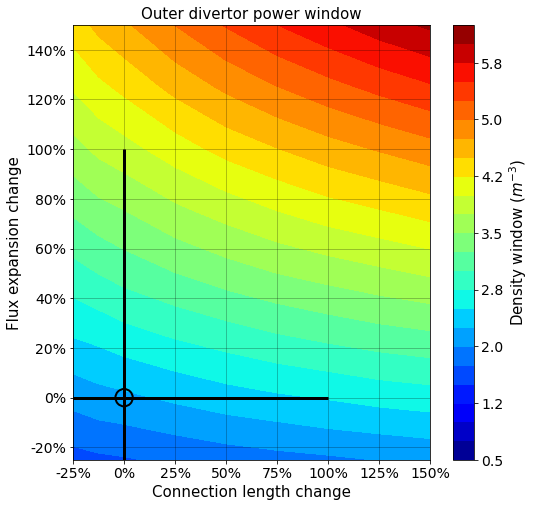

In [104]:
arr = make_arrays(ne_kAr_wide["ou"], list_BxBt_scales2, list_Lc_scales2)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales2-1, list_BxBt_scales2-1, arr["window_ratio"], levels = 22, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.25,1.5)
ax.set_ylim(-0.25,1.5)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Relative density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor power window", fontsize = 15)

# Old

In [6]:
def patch_array(array, percentile_threshold):
    # Take 2D numpy array
    # Take out values above threshold and replace with interpolated ones
    # https://stackoverflow.com/questions/37662180/interpolate-missing-values-2d-python

    original = array.copy()
    x = list_BxBt_scales
    y = list_Lc_scales

    # original[original > threshold] = np.nan
    original[original > np.percentile(original, percentile_threshold)] = np.nan
    print("Eliminated {} values.".format(len(original[original > np.percentile(original, percentile_threshold)])))

    original = np.ma.masked_invalid(original)
    xx, yy = np.meshgrid(x,y)

    x1 = xx[~original.mask]
    y1 = yy[~original.mask]

    new = original[~original.mask]

    filled = interpolate.griddata((x1, y1), new.ravel(), (xx,yy), method = "cubic")
    return filled